In [2]:
import argparse
import random
import numpy as np
import os
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import glob
import librosa
import torchaudio
import torchaudio.transforms as AT
import matplotlib.pyplot as plt
import json

from covidxdataset import COVIDxDataset
from audiodataset import CoswaraDataset
import util as util
from util import Mel2Samp
from train import train, validation
from model import transfer_resNet, ResNet54, ResNet22, ResNet38

In [3]:
data_path = '../data/Coswara-Data/20*/*/'
pid_list = glob.glob(data_path)

paths = []
labels = []
for pid in pid_list:
    json_file = pid + 'metadata.json'
    with open(json_file) as json_file:
        json_data = json.load(json_file)
        status = json_data["covid_status"]
    if 'positive' in status:
        status = 'positive'
    if status != 'healthy' and status != 'positive':
        continue
    file_list = glob.glob(pid + '*.wav')
    for f in file_list:
        if 'cough' not in f:
            continue
        paths.append(f)
        labels.append(status)

In [3]:
mel_spectrogram = nn.Sequential(
            AT.MelSpectrogram(sample_rate=16000, 
                              n_fft=512, 
                              win_length=400,
                              hop_length=160,
                              n_mels=80,
#                               f_max=8000
                             ),
            AT.AmplitudeToDB()
)


In [4]:
mel_spectrogram = nn.Sequential(
            AT.MelSpectrogram(sample_rate=16000, 
                              n_fft=1024, 
                              win_length=1024,
                              hop_length=320,
                              n_mels=64,
                              f_max=8000
                             ),
            AT.AmplitudeToDB()
)


In [4]:
audio, sr = librosa.load(paths[0], sr=16000)
# audio = torch.from_numpy(audio)
# mel = mel_spectrogram(audio)

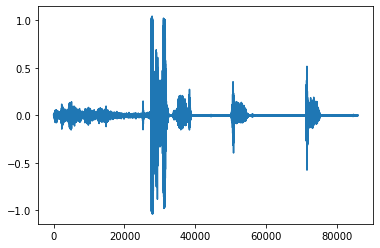

In [7]:
plt.plot(audio)

In [9]:
np.argmax(audio)

27821

In [15]:
segment_length = 16000*4
audio_start = np.argmax(audio) - segment_length//2
if audio_start < 0:
    audio_start = 0
audio_s = audio[audio_start:audio_start + segment_length]

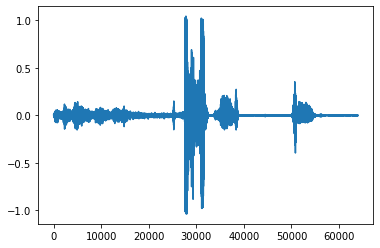

In [17]:
plt.plot(audio_s)

In [16]:
audio_s.shape

(64000,)

In [5]:
audio.shape

(86016,)

In [6]:
segment_length = 16000*6
# Take segment
if audio.shape[0] >= segment_length:
    max_audio_start = audio.shape[0] - segment_length
    audio_start = random.randint(0, max_audio_start)
    audio_s = audio[audio_start:audio_start + segment_length]
else:
    audio = torch.nn.functional.pad(audio, (0, segment_length - audio.shape[0]), 'constant').data

In [7]:
mel = mel_spectrogram(torch.from_numpy(audio))

/home/u00u654jzhiF9LTXS9357/.local/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/u00u654jzhiF9LTXS9357/.local/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [8]:
mel2 = mel_spectrogram(torch.from_numpy(audio_s))

In [9]:
mel2.shape

torch.Size([64, 301])

In [10]:
mel.shape, mel2.shape

(torch.Size([64, 414]), torch.Size([64, 301]))

In [11]:
audio2, sr = librosa.load(paths[10], sr=16000)

In [12]:
mel2 = mel2.unsqueeze(0)

In [13]:
melkwargs={"n_fft": 400, "hop_length": 160, "win_length": 400, "n_mels": 80, "f_max": 8000}
mfcc = AT.MFCC(sample_rate=sr, n_mfcc=40, melkwargs=melkwargs)(torch.from_numpy(audio))

In [14]:
mfcc = mfcc.unsqueeze(0).unsqueeze(0)
mfcc.transpose(2, 3).shape

torch.Size([1, 1, 828, 40])

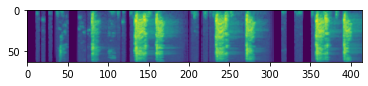

In [15]:
plt.imshow(mel)

In [16]:
mfcc2 = librosa.feature.mfcc(audio, sr=sr, n_mfcc=20,n_fft=512, 
                              hop_length=160,
                              n_mels=80)

In [17]:
mfcc2.shape

(20, 828)

In [18]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

In [19]:
seed = 20
seed_everything(seed)

num_classes = 2
# model = transfer_resNet(num_classes)
model = ResNet22(2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 64
train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 10}

test_params = {'batch_size': batch_size,
               'shuffle': False,
               'num_workers': 7}

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataset_name = 'coswara'
if dataset_name == 'coswara':
    train_dataset = CoswaraDataset(mode='train', n_classes=num_classes, segment_length=16000*4)
    val_dataset = CoswaraDataset(mode='valid', n_classes=num_classes, segment_length=16000*4)
    test_dataset = CoswaraDataset(mode='test', n_classes=num_classes, segment_length=16000*4)
    
    train_loader = DataLoader(train_dataset, **train_params)
    val_loader = DataLoader(val_dataset, **test_params)
    test_loader = DataLoader(test_dataset, **test_params)

    train_loader = DataLoader(train_dataset, **train_params)
    val_loader = DataLoader(val_dataset, **test_params)
    test_loader = DataLoader(test_dataset, **test_params)

# print(model)
num_epochs = 30
best_pred_loss = 1000.0
lr_sch = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-7, verbose=True)
# lr_sch = ExponentialLR(optimizer, gamma=0.975)

for epoch in range(1, num_epochs + 1):
    train(device, batch_size, model, train_loader, optimizer, epoch, None)
    val_metrics, confusion_matrix = validation(device, batch_size, num_classes, model, test_loader, epoch, None)

#     best_pred_loss = util.save_model(model, optimizer, args, val_metrics, epoch, best_pred_loss, confusion_matrix)
    
    lr_sch.step(val_metrics.avg('loss'))
#     lr_sch.step()

train examples =  259 [130 129]
valid examples =  26 [13 13]
test examples =  65 [32 33]
Epoch: 1	Sample:    1/  259	Loss:2.0720	Accuracy:0.53
Training
 SUMMARY EPOCH: 1	Sample:  259/  259	Loss:2.8469	Accuracy:0.54

Confusion Matrix
[[69. 61.]
 [58. 71.]]

Validation
 SUMMARY EPOCH: 1	Sample:   65/   65	Loss:0.8057	Accuracy:0.51

Confusion Matrix
[[ 0. 32.]
 [ 0. 33.]]
Epoch: 2	Sample:    1/  259	Loss:3.4921	Accuracy:0.58
Training
 SUMMARY EPOCH: 2	Sample:  259/  259	Loss:2.4344	Accuracy:0.56

Confusion Matrix
[[68. 62.]
 [53. 76.]]

Validation
 SUMMARY EPOCH: 2	Sample:   65/   65	Loss:0.7103	Accuracy:0.62

Confusion Matrix
[[15. 17.]
 [ 8. 25.]]
Epoch: 3	Sample:    1/  259	Loss:1.0362	Accuracy:0.56
Training
 SUMMARY EPOCH: 3	Sample:  259/  259	Loss:1.1972	Accuracy:0.59

Confusion Matrix
[[76. 54.]
 [52. 77.]]

Validation
 SUMMARY EPOCH: 3	Sample:   65/   65	Loss:0.7300	Accuracy:0.54

Confusion Matrix
[[28.  4.]
 [26.  7.]]
Epoch: 4	Sample:    1/  259	Loss:0.6475	Accuracy:0.66
Training

In [ ]:
# cough 1:1
train examples =  259 [130 129]
test examples =  65 [32 33]
# mfcc(40-40), mel(40)
Epoch:30	Sample:    1/  259	Loss:0.3746	Accuracy:0.84
Training
 SUMMARY EPOCH:30	Sample:  259/  259	Loss:0.3262	Accuracy:0.88

Confusion Matrix
[[110.  20.]
 [ 19. 110.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.5281	Accuracy:0.85

Confusion Matrix
[[21. 11.]
 [ 8. 25.]]
# mfcc(80-40), mel(40)
Epoch:30	Sample:    1/  259	Loss:0.3846	Accuracy:0.84
Training
 SUMMARY EPOCH:30	Sample:  259/  259	Loss:0.2643	Accuracy:0.90

Confusion Matrix
[[116.  14.]
 [ 15. 114.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.4694	Accuracy:0.81

Confusion Matrix
[[23.  9.]
 [ 9. 24.]]
# mfcc, 0.0001, res22, asym 제거
Epoch:30	Sample:    1/  259	Loss:0.3649	Accuracy:0.81
Training
 SUMMARY EPOCH:30	Sample:  259/  259	Loss:0.3580	Accuracy:0.86

Confusion Matrix
[[113.  17.]
 [ 22. 107.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.6397	Accuracy:0.80

Confusion Matrix
[[13. 19.]
 [ 0. 33.]]

# mel, 0.0001, res22, asym 제거
Epoch:30	Sample:    1/  259	Loss:0.4553	Accuracy:0.88
Training
 SUMMARY EPOCH:30	Sample:  259/  259	Loss:0.3001	Accuracy:0.90

Confusion Matrix
[[118.  12.]
 [ 16. 113.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.4492	Accuracy:0.80

Confusion Matrix
[[26.  6.]
 [13. 20.]]

In [ ]:
# mel, 0.0001, res54
Epoch:30	Sample:    1/  320	Loss:0.1517	Accuracy:1.00
Training
 SUMMARY EPOCH:30	Sample:  289/  289	Loss:0.2588	Accuracy:0.92

Confusion Matrix
[[143.   9.]
 [ 16. 136.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.7340	Accuracy:0.63

Confusion Matrix
[[27. 11.]
 [16. 22.]]
# MFCC, 0.0001, res54
Epoch:30	Sample:    1/  320	Loss:0.2430	Accuracy:0.91
Training
 SUMMARY EPOCH:30	Sample:  289/  289	Loss:0.2133	Accuracy:0.92

Confusion Matrix
[[142.  10.]
 [ 17. 135.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:1.0175	Accuracy:0.60

Confusion Matrix
[[13. 25.]
 [ 3. 35.]]

In [ ]:
# mel, 0.0001, res22, pretrain
Epoch:23	Sample:    1/  320	Loss:0.1552	Accuracy:0.97
Training
 SUMMARY EPOCH:23	Sample:  289/  289	Loss:0.1572	Accuracy:0.98

Confusion Matrix
[[148.   4.]
 [  2. 150.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:23	Sample:   65/   65	Loss:0.5647	Accuracy:0.68

Confusion Matrix
[[29.  9.]
 [13. 25.]]
('loss', 'correct', 'total', 'accuracy')
# mel, 0.0001, res22, aug
SUMMARY EPOCH:30	Sample:  289/  289	Loss:0.3985	Accuracy:0.81
Confusion Matrix
[[126.  26.]
 [ 31. 121.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.6168	Accuracy:0.64
Confusion Matrix
[[24. 14.]
 [12. 26.]]
# mel, 0.0001, res22
Training
 SUMMARY EPOCH:28	Sample:  289/  289	Loss:0.3153	Accuracy:0.87

Confusion Matrix
[[134.  18.]
 [ 20. 132.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:28	Sample:   65/   65	Loss:0.6228	Accuracy:0.74

Confusion Matrix
[[29.  9.]
 [11. 27.]]
# MFCC, 0.0001, res22
Epoch:30	Sample:    1/  320	Loss:0.3386	Accuracy:0.84
Training
 SUMMARY EPOCH:30	Sample:  289/  289	Loss:0.3717	Accuracy:0.83

Confusion Matrix
[[125.  27.]
 [ 23. 129.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:30	Sample:   65/   65	Loss:0.5852	Accuracy:0.75

Confusion Matrix
[[24. 14.]
 [ 3. 35.]]

In [ ]:
# mel, 0.0001, shape 다르게
Confusion Matrix
[[12. 26.]
 [ 3. 35.]]
Epoch    28: reducing learning rate of group 0 to 1.5625e-06.
('loss', 'correct', 'total', 'accuracy')
Epoch:29	Sample:    1/  320	Loss:0.2735	Accuracy:0.94
Training
 SUMMARY EPOCH:29	Sample:  289/  289	Loss:0.3475	Accuracy:0.85

Confusion Matrix
[[133.  19.]
 [ 27. 125.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:29	Sample:   65/   65	Loss:1.0067	Accuracy:0.60

Confusion Matrix
[[14. 24.]
 [ 4. 34.]]

In [ ]:
# MFCC, 0.0001, shape 다르게
Training
 SUMMARY EPOCH:25	Sample:  289/  289	Loss:0.2372	Accuracy:0.92

Confusion Matrix
[[136.  16.]
 [ 11. 141.]]
('loss', 'correct', 'total', 'accuracy')
Validation
 SUMMARY EPOCH:25	Sample:   65/   65	Loss:0.6516	Accuracy:0.75

Confusion Matrix
[[32.  6.]
 [15. 23.]]

In [ ]:
test_metrics, confusion_matrix = validation(device, batch_size, num_classes, model, test_loader, epoch, None)